In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports, constants and paths

In [34]:
from os import listdir
import os
from collections import defaultdict
import random
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from numpy import asarray
from skimage.metrics import structural_similarity as ssim
import skimage
import shutil
from collections import Counter
import collections
#from collections import subtract

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/bin/python3
3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
sys.version_info(major=3, minor=7, micro=13, releaselevel='final', serial=0)


In [120]:
root_directory = "/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/"
plots = root_directory + 'plots/'
preprocessed_data = root_directory + "preprocessed_data/"
originaltrainset = root_directory + "originaltrainset/"
augmented_data = root_directory + "augmented_data/"
original_and_augmented = root_directory + "original_and_augmented/"
testset1_path = root_directory + "testset1/"
testset2_path = root_directory + "testset2/"
valset1_path = root_directory + "valset1/"
valset2_path = root_directory + "valset2/"
valset3_path = root_directory + "valset3/"
trainset1_path = root_directory + "trainset1/"
trainset2_path = root_directory + "trainset2/"
trainset3_path = root_directory + "trainset3/"

### Functions

In [12]:
def load_images_data(path):
    """Loads images from given google drive path and save info about their names into a dictionary. 

    Parameters
    ----------
    path : path
        The file location in the google drive

    Returns
    -------
    dict
        a dictionary with lists for every class name
    """

    data_dict = defaultdict(list)
    classes_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']
    motorcycles_list, bicycles_list, busses_list, cars_list, trucks_list = list(), list(), list(), list(), list()
    classes_list = [motorcycles_list, bicycles_list, busses_list, cars_list, trucks_list]

    for _class_name, _class_list in list(zip(classes_names, classes_list)):
        _class_list = listdir(path + _class_name)
        data_dict[_class_name] = _class_list

    return data_dict

In [13]:
def check_number_of_images(input_dictionary):
    """Checks how many pictures are loaded for every class. 

    Parameters
    ----------
    input_dictionary : dict
        The dictionary with lists of images names for every class

    Returns
    -------
    dict
        a dictionary with number of elements for evey class
    """
    statistics_dict = defaultdict(int)
    classes_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']

    for _class_name in classes_names:
        statistics_dict[_class_name] = len(input_dictionary[_class_name])

    return statistics_dict

In [41]:
def generate_set(set_space, path, threshold=0.01, cor_threshold=0.49, check_around_threshold=15):
    """
    Take images space, check correlations between them and return final set for machine learning task. 
    """

    THRESHOLD = threshold # how many pictures do I need in every class (percentage value)
    COR_THRESHOLD = cor_threshold #0.87 # how many seconds between taking pictures in order not to be correlated
    CHECK_AROUND_THRESHOLD = check_around_threshold # how many next pictures to check in order to find correlated ones; correlated pictures were saved near each other

    set_space = set_space

    set_dict = defaultdict(list)
    motorcycles_list, bicycles_list, busses_list, cars_list, trucks_list = list(), list(), list(), list(), list()
    classes_list = [motorcycles_list, bicycles_list, busses_list, cars_list, trucks_list]
    classes_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']

    for _class_name, _class_list_name in list(zip(classes_names, classes_list)):  

        current_class = classes_names.index(_class_name) + 1
        temporary_space = set_space[_class_name] # choose data within one class - it is a list of picture names
        REQUIRED_NUMBER_OF_PICTURES = int(THRESHOLD*len(temporary_space))

        i = 0; 
        while i < REQUIRED_NUMBER_OF_PICTURES: # until we achieve required number of pictures
            print(f"class = {current_class}/{len(classes_names)}; iterator = {i}/{REQUIRED_NUMBER_OF_PICTURES}")
          
            considered_image = random.sample(temporary_space, k=1) # randomly choose one element from the list
            _class_list_name.append(considered_image[0]) # add image to the test set 
            i += 1 # increment iterator
            considered_image_index = temporary_space.index(considered_image[0]) # caculate image index in the list
            temporary_space = set(temporary_space).difference(set(_class_list_name)) # update iteration list (substract this one correlated element which have already been found)
            temporary_space = list(temporary_space)
            # load considered image
            path_last_part = considered_image[0] # because tuples are not mutable
            #if path_last_part.endswith(".jpeg"):
            #    path_last_part = path_last_part.replace("jpeg", "JPEG")
            considered_image_path = path + _class_name + "/" + path_last_part
            considered_im = Image.open(considered_image_path)
            considered_im = asarray(considered_im)

            for image_name in temporary_space[considered_image_index:considered_image_index + CHECK_AROUND_THRESHOLD]:
                # load image
                #if image_name.endswith(".jpeg"):
                #    image_name = image_name.replace("jpeg", "JPEG")
                image_path = path + _class_name + "/" + image_name
                im = Image.open(image_path)
                im = asarray(im)
                # calculate correlation
                try:
                    cor = ssim(considered_im, im, multichannel=True)   
                except:
                    pass          
                if cor > COR_THRESHOLD:
                    print(cor)
                    i += 1 # upgrade iterator - one more correlated picture found
                    _class_list_name.append(image_name) # add image name to the set

            temporary_space = set(temporary_space).difference(set(_class_list_name)) # update iteration list (substract correlated elements which have already been found)
            temporary_space = list(temporary_space) # make list from set
            # end of while loop iteration
          
        #print("length after subtraction", len(temporary_space))

    #end of classes_names for loop iteration

    set_dict['motorcycle'] = motorcycles_list
    set_dict['bicycle'] = bicycles_list
    set_dict['bus'] = busses_list
    set_dict['car'] = cars_list
    set_dict['truck'] = trucks_list

    return set_dict

In [67]:
def copy_to_file(dataset, from_path, to_path):
    """
    Takes dict with lists with images names, copy those image to the desired location. 
    """

    for key in dataset.keys():
        for image_name in dataset[key]:
            original_path = from_path + key + '/' + image_name
            target_path = to_path + key + '/' + image_name
            shutil.copyfile(original_path, target_path)

In [ ]:
def normalize(path):
    # normalize from [-1, 1] -> tensorflow input
    image = Image.open(original_path)
    image = asarray(image)
    new_image_array = image / 127.5
    new_image_array = new_image_array - 1
    print(new_image_array)
    print(target_path)
    new_image = Image.fromarray(new_image_array)
    new_image.save(target_path)
    new_image.close() 
    image.close() # remember to close the image - memory issue

## Train and validation sets generation
Correlation between images will be calculated using Structural similarity index(SSIM). The maximum value of 1 indicates that the two signals are perfectly structurally similar while a value of 0 indicates no structural similarity. We decide that the pair of images will be treated as correlated if SSIM measure will be higher than 0.49 (even the poor correlation will be taken into account). 
 - https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html

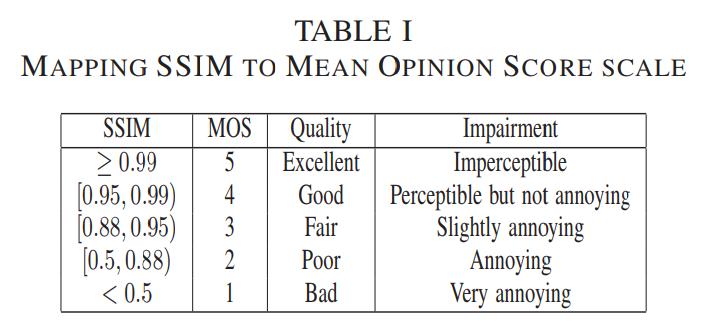

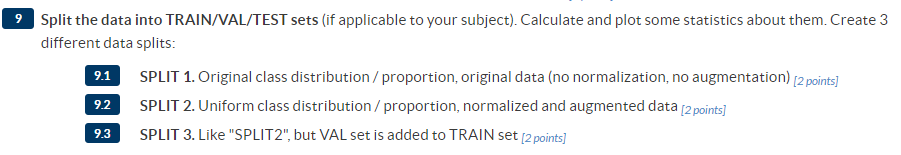

### SPLIT 1: 20% of the train data will go to the validation set

In [77]:
data_dict = load_images_data(originaltrainset)
print(data_dict)
check_number_of_images(data_dict)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1491.JPEG', 'motorcycle1492.JPEG', 'motorcycle1493.JPEG', 'motorcycle1494.JPEG', 'motorcycle1495.JPEG', 'motorcycle1496.JPEG', 'motorcycle1497.JPEG', 'motorcycle1498.JPEG', 'motorcycle1499.JPEG', 'motorcycle1500.JPEG', 'motorcycle1501.JPEG', 'motorcycle1502.JPEG', 'motorcycle1503.JPEG', 'motorcycle1504.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1508.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1513.JPEG', 'motorcycle1514.JPEG', 'motorcycle1516.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1525.JPEG', 'motorcycle1526.JPEG', 'motorcycle1527.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1530.JPEG', 'motorcycle1531.JPEG', 'motorcycle1534.JPEG', 'motorcycle1535.JPEG', 'motorcycle15

defaultdict(int,
            {'bicycle': 246,
             'bus': 922,
             'car': 3342,
             'motorcycle': 2346,
             'truck': 912})

In [81]:
valset1 = generate_set(set_space=data_dict, path=originaltrainset, threshold=0.2)
print(valset1)

class = 1/5; iterator = 0/469
0.4906313343091732
class = 1/5; iterator = 2/469
class = 1/5; iterator = 3/469
class = 1/5; iterator = 4/469
class = 1/5; iterator = 5/469
class = 1/5; iterator = 6/469
class = 1/5; iterator = 7/469
class = 1/5; iterator = 8/469
class = 1/5; iterator = 9/469
class = 1/5; iterator = 10/469
0.5811312356532999
0.5221084638327794
class = 1/5; iterator = 13/469
class = 1/5; iterator = 14/469
class = 1/5; iterator = 15/469
class = 1/5; iterator = 16/469
class = 1/5; iterator = 17/469
class = 1/5; iterator = 18/469
class = 1/5; iterator = 19/469
class = 1/5; iterator = 20/469
0.5038847362715524
0.5098033066546427
0.4956870224690864
class = 1/5; iterator = 24/469
class = 1/5; iterator = 25/469
class = 1/5; iterator = 26/469
class = 1/5; iterator = 27/469
class = 1/5; iterator = 28/469
class = 1/5; iterator = 29/469
class = 1/5; iterator = 30/469
class = 1/5; iterator = 31/469
class = 1/5; iterator = 32/469
class = 1/5; iterator = 33/469
0.5180219679537013
0.595840

In [ ]:
copy_to_file(dataset=valset1, from_path=originaltrainset, to_path=valset1_path)

In [101]:
valset1_stats = check_number_of_images(valset1)
valset1_stats

defaultdict(int,
            {'bicycle': 49,
             'bus': 184,
             'car': 668,
             'motorcycle': 470,
             'truck': 182})

In [ ]:
data_dict.keys()

dict_keys(['motorcycle', 'bicycle', 'bus', 'car', 'truck'])

In [98]:
trainset1 = defaultdict(list)
for _class_name in data_dict.keys():
    trainset1[_class_name] = [item for item in data_dict[_class_name] if item not in valset1[_class_name]]
    
print(trainset1)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1492.JPEG', 'motorcycle1493.JPEG', 'motorcycle1494.JPEG', 'motorcycle1495.JPEG', 'motorcycle1496.JPEG', 'motorcycle1500.JPEG', 'motorcycle1501.JPEG', 'motorcycle1502.JPEG', 'motorcycle1503.JPEG', 'motorcycle1504.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1508.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1513.JPEG', 'motorcycle1514.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1526.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1531.JPEG', 'motorcycle1534.JPEG', 'motorcycle1535.JPEG', 'motorcycle1537.JPEG', 'motorcycle1538.JPEG', 'motorcycle1541.JPEG', 'motorcycle1542.JPEG', 'motorcycle1543.JPEG', 'motorcycle1544.JPEG', 'motorcycle1546.JPEG', 'motorcycle1547.JPEG', 'motorcycle15

In [ ]:
copy_to_file(dataset=trainset1, from_path=originaltrainset, to_path=trainset1_path)

In [100]:
trainset1_stats = check_number_of_images(trainset1)
trainset1_stats

defaultdict(int,
            {'bicycle': 197,
             'bus': 738,
             'car': 2674,
             'motorcycle': 1876,
             'truck': 730})

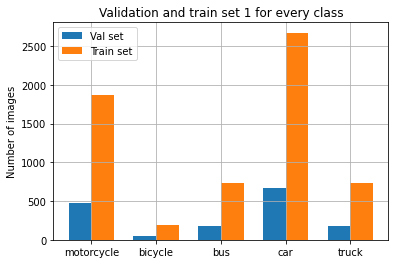

In [113]:
N = 5
val_set_data = valset1_stats.values()
train_set_data = trainset1_stats.values()

plt.figure()
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, val_set_data, width, label='Val set')
plt.bar(ind + width, train_set_data, width, label='Train set')

plt.ylabel('Number of images')
plt.title('Validation and train set 1 for every class')

plt.xticks(ind + width / 2, ['motorcycle', 'bicycle', 'bus', 'car', 'truck'])
plt.legend(loc='best')
plt.grid(True)
plt.savefig(plots + "valtrainset1.png")
plt.show()

### SPLIT 2: 20% of the train data will go to the validation set. We will use original and augmented data. Data will be normalized. Normalization will be at later step (before model training), because of the fact that image normalized in the range [-1, 1] can't be saved in the file as an image. Tensorflow input requires input normalized in the range [-1, 1]. 

##### Move all the data (original + augmented) to one file

In [7]:
classes_names = ['motorcycle', 'bicycle', 'bus', 'car', 'truck']

path1 = augmented_data #originaltrainset

for _class_name in classes_names:
    _class_list = listdir(path1 + _class_name)
    for image in _class_list:
        original_path = path1 + _class_name + '/' + image
        target_path = original_and_augmented + _class_name + '/' + image
        shutil.copyfile(original_path, target_path)

##### Perform normalization and divide the data into val and train set

In [42]:
data_dict2 = load_images_data(original_and_augmented)
print(data_dict2)
check_number_of_images(data_dict2)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1491.JPEG', 'motorcycle1492.JPEG', 'motorcycle1493.JPEG', 'motorcycle1494.JPEG', 'motorcycle1495.JPEG', 'motorcycle1496.JPEG', 'motorcycle1497.JPEG', 'motorcycle1498.JPEG', 'motorcycle1499.JPEG', 'motorcycle1500.JPEG', 'motorcycle1501.JPEG', 'motorcycle1502.JPEG', 'motorcycle1503.JPEG', 'motorcycle1504.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1508.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1513.JPEG', 'motorcycle1514.JPEG', 'motorcycle1516.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1525.JPEG', 'motorcycle1526.JPEG', 'motorcycle1527.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1530.JPEG', 'motorcycle1531.JPEG', 'motorcycle1534.JPEG', 'motorcycle1535.JPEG', 'motorcycle15

defaultdict(int,
            {'bicycle': 3297,
             'bus': 3266,
             'car': 3342,
             'motorcycle': 3296,
             'truck': 3236})

In [ ]:
valset2 = generate_set(set_space=data_dict2, path=original_and_augmented, threshold=0.2)
print(valset2)

In [58]:
print(valset2)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle470.JPEG', '_2222_5737.jpeg', 'motorcycle62.JPEG', '_1046_4737.jpeg', '_2290_6511.jpeg', 'motorcycle500.JPEG', 'motorcycle949.JPEG', 'motorcycle1371.JPEG', 'motorcycle325.JPEG', '_2097_2880.jpeg', 'motorcycle294.JPEG', 'motorcycle974.JPEG', '_1838_1371.jpeg', 'motorcycle2261.JPEG', 'motorcycle1508.JPEG', 'motorcycle1781.JPEG', '_1606_8029.jpeg', 'motorcycle907.JPEG', 'motorcycle839.JPEG', '_287_3962.jpeg', '_1329_7604.jpeg', 'motorcycle1764.JPEG', '_1537_1685.jpeg', '_2181_828.jpeg', 'motorcycle437.JPEG', '_474_9869.jpeg', 'motorcycle1301.JPEG', 'motorcycle1138.JPEG', 'motorcycle1350.JPEG', 'motorcycle1589.JPEG', 'motorcycle1227.JPEG', 'motorcycle1143.JPEG', 'motorcycle371.JPEG', 'motorcycle177.JPEG', '_1940_3903.jpeg', 'motorcycle1042.JPEG', '_1080_5539.jpeg', 'motorcycle265.JPEG', 'motorcycle680.JPEG', 'motorcycle1078.JPEG', 'motorcycle244.JPEG', '_320_7181.jpeg', 'motorcycle465.JPEG', 'motorcycle1238.JPEG', 'motorcycle560.JPEG',

In [33]:
ls

drive/  sample_data/


In [39]:
os.listdir('/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/originaltrainset')
# Image.open(r'/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/originaltrainset/motorcycle/_233_1892.jpeg')

['bus', 'truck', 'car', 'motorcycle', 'bicycle']

 - FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/originaltrainset/motorcycle/_233_1892.jpeg'
 - problem was with the "originaltrainset" path - it was harcoded in the function

In [64]:
copy_to_file(dataset=valset2, from_path=original_and_augmented, to_path=valset2_path)

motorcycle
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/original_and_augmented/motorcycle/motorcycle470.JPEG
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/valset2/motorcycle/motorcycle470.JPEG
bicycle
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/original_and_augmented/bicycle/bicycle151.JPEG
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/valset2/bicycle/bicycle151.JPEG
bus
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/original_and_augmented/bus/_148_9101.jpeg
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/valset2/bus/_148_9101.jpeg
car
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/original_and_augmented/car/car1397.JPEG
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/valset2/car/car1397.JPEG
truck
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/original_and_augmented/truck/_721_3696.jpeg
/content/drive/My Drive/2022_Projekt_badawczy/ZPD_SZUM/valset2/truck/_721_3696.jpeg


In [82]:
valset2_stats = check_number_of_images(valset2)
valset2_stats

defaultdict(int,
            {'bicycle': 659,
             'bus': 653,
             'car': 668,
             'motorcycle': 659,
             'truck': 647})

In [68]:
data_dict.keys()

dict_keys(['motorcycle', 'bicycle', 'bus', 'car', 'truck'])

In [69]:
trainset2 = defaultdict(list)
for _class_name in data_dict.keys():
    trainset2[_class_name] = [item for item in data_dict[_class_name] if item not in valset2[_class_name]]
    
print(trainset2)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1493.JPEG', 'motorcycle1494.JPEG', 'motorcycle1495.JPEG', 'motorcycle1496.JPEG', 'motorcycle1497.JPEG', 'motorcycle1498.JPEG', 'motorcycle1499.JPEG', 'motorcycle1500.JPEG', 'motorcycle1501.JPEG', 'motorcycle1502.JPEG', 'motorcycle1503.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1514.JPEG', 'motorcycle1516.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1526.JPEG', 'motorcycle1527.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1530.JPEG', 'motorcycle1531.JPEG', 'motorcycle1534.JPEG', 'motorcycle1535.JPEG', 'motorcycle1536.JPEG', 'motorcycle1537.JPEG', 'motorcycle1540.JPEG', 'motorcycle1541.JPEG', 'motorcycle1542.JPEG', 'motorcycle1543.JPEG', 'motorcycle15

In [83]:
trainset2_stats = check_number_of_images(trainset2)
trainset2_stats

defaultdict(int,
            {'bicycle': 2638,
             'bus': 2613,
             'car': 2674,
             'motorcycle': 2637,
             'truck': 2589})

In [71]:
copy_to_file(dataset=trainset2, from_path=original_and_augmented, to_path=trainset2_path)

In [84]:
valset2_stats.values()

dict_values([659, 659, 653, 668, 647])

In [87]:
valset2_stats.keys()

dict_keys(['motorcycle', 'bicycle', 'bus', 'car', 'truck'])

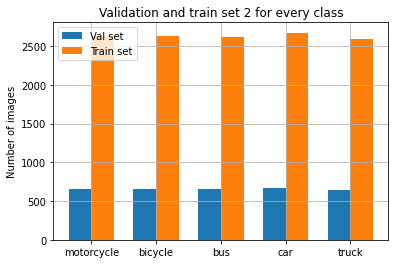

In [114]:
N = 5
val_set_data = valset2_stats.values()
train_set_data = trainset2_stats.values()


ind = np.arange(N) 
width = 0.35
plt.figure()       
plt.bar(ind, val_set_data, width, label='Val set')
plt.bar(ind + width, train_set_data, width, label='Train set')

plt.ylabel('Number of images')
plt.title('Validation and train set 2 for every class')

plt.xticks(ind + width / 2, ['motorcycle', 'bicycle', 'bus', 'car', 'truck'])
plt.legend(loc='best')
plt.grid(True)
plt.savefig(plots + "valtrainset2.png")
plt.show()

### SPLIT 3: 20% of the train data will go to the validation set. Train dataset will also contain validation data. We will use original and augmented data. Data will be normalized. Normalization will be at later step (before model training), because of the fact that image normalized in the range [-1, 1] can't be saved in the file as an image. Tensorflow input requires input normalized in the range [-1, 1]. 

In [73]:
copy_to_file(dataset=valset2, from_path=original_and_augmented, to_path=valset3_path)

In [74]:
check_number_of_images(valset2)

defaultdict(int,
            {'bicycle': 659,
             'bus': 653,
             'car': 668,
             'motorcycle': 659,
             'truck': 647})

In [75]:
copy_to_file(dataset=data_dict2, from_path=original_and_augmented, to_path=trainset3_path)

In [109]:
data_dict2_stats = check_number_of_images(data_dict2)
data_dict2_stats

defaultdict(int,
            {'bicycle': 3297,
             'bus': 3266,
             'car': 3342,
             'motorcycle': 3296,
             'truck': 3236})

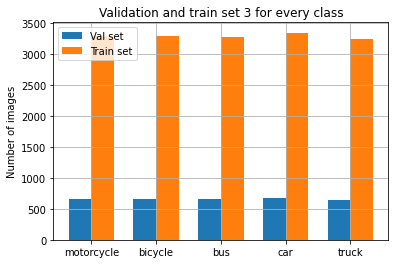

In [140]:
N = 5
val_set_data = valset2_stats.values()
train_set_data = data_dict2_stats.values()


ind = np.arange(N) 
width = 0.35
plt.figure()       
plt.bar(ind, val_set_data, width, label='Val set')
plt.bar(ind + width, train_set_data, width, label='Train set')

plt.ylabel('Number of images')
plt.title('Validation and train set 3 for every class')

plt.xticks(ind + width / 2, ['motorcycle', 'bicycle', 'bus', 'car', 'truck'])
plt.legend(loc='best')
plt.grid(True)
plt.savefig(plots + "valtrainset3.JPEG")
plt.show()

# Plots

In [118]:
beginning_data_dict = load_images_data(preprocessed_data)
print(beginning_data_dict)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1504.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1507.JPEG', 'motorcycle1508.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1513.JPEG', 'motorcycle1514.JPEG', 'motorcycle1515.JPEG', 'motorcycle1516.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1525.JPEG', 'motorcycle1526.JPEG', 'motorcycle1527.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1530.JPEG', 'motorcycle1531.JPEG', 'motorcycle1532.JPEG', 'motorcycle1533.JPEG', 'motorcycle1534.JPEG', 'motorcycle1621.JPEG', 'motorcycle1535.JPEG', 'motorcycle1536.JPEG', 'motorcycle7.JPEG', 'motorcycle8.JPEG', 'motorcycle9.JPEG', 'motorcycle0.JPEG', 'motorcycle1622.JPEG', 'motorcycle1.JPEG', 'motorcycle2.JPEG', 'motorcycle4.JPEG', 'motorcycle

In [119]:
beginning_data_stats = check_number_of_images(beginning_data_dict)
beginning_data_stats

defaultdict(int,
            {'bicycle': 421,
             'bus': 1105,
             'car': 3533,
             'motorcycle': 2537,
             'truck': 1093})

In [121]:
testset1 = load_images_data(testset1_path)
print(testset1)

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle38.JPEG', 'motorcycle41.JPEG', 'motorcycle36.JPEG', 'motorcycle42.JPEG', 'motorcycle44.JPEG', 'motorcycle35.JPEG', 'motorcycle37.JPEG', 'motorcycle43.JPEG', 'motorcycle33.JPEG', 'motorcycle34.JPEG', 'motorcycle39.JPEG', 'motorcycle40.JPEG', 'motorcycle27.JPEG', 'motorcycle31.JPEG', 'motorcycle32.JPEG', 'motorcycle28.JPEG', 'motorcycle30.JPEG', 'motorcycle29.JPEG', 'motorcycle16.JPEG', 'motorcycle19.JPEG', 'motorcycle23.JPEG', 'motorcycle15.JPEG', 'motorcycle17.JPEG', 'motorcycle21.JPEG', 'motorcycle20.JPEG', 'motorcycle24.JPEG', 'motorcycle25.JPEG', 'motorcycle14.JPEG', 'motorcycle26.JPEG', 'motorcycle18.JPEG', 'motorcycle22.JPEG'], 'bicycle': ['bicycle34.JPEG', 'bicycle31.JPEG', 'bicycle32.JPEG', 'bicycle33.JPEG', 'bicycle26.JPEG', 'bicycle23.JPEG', 'bicycle30.JPEG', 'bicycle20.JPEG', 'bicycle25.JPEG', 'bicycle17.JPEG', 'bicycle19.JPEG', 'bicycle22.JPEG', 'bicycle24.JPEG', 'bicycle16.JPEG', 'bicycle29.JPEG', 'bicycle47.JPEG', 'bic

In [122]:
testset1_stats = check_number_of_images(testset1)
testset1_stats

defaultdict(int,
            {'bicycle': 25,
             'bus': 23,
             'car': 31,
             'motorcycle': 31,
             'truck': 21})

In [123]:
testset2 = load_images_data(testset2_path)
print(testset2)
testset2_stats = check_number_of_images(testset2)
testset2_stats

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1532.JPEG', 'motorcycle382.JPEG', 'motorcycle2031.JPEG', 'motorcycle331.JPEG', 'motorcycle229.JPEG', 'motorcycle2505.JPEG', 'motorcycle2425.JPEG', 'motorcycle1886.JPEG', 'motorcycle1960.JPEG', 'motorcycle1243.JPEG', 'motorcycle1236.JPEG', 'motorcycle1533.JPEG', 'motorcycle455.JPEG', 'motorcycle1036.JPEG', 'motorcycle2419.JPEG', 'motorcycle324.JPEG', 'motorcycle1391.JPEG', 'motorcycle1664.JPEG', 'motorcycle638.JPEG', 'motorcycle2207.JPEG', 'motorcycle1596.JPEG', 'motorcycle1598.JPEG', 'motorcycle1022.JPEG', 'motorcycle988.JPEG', 'motorcycle823.JPEG', 'motorcycle2490.JPEG', 'motorcycle1795.JPEG', 'motorcycle1356.JPEG', 'motorcycle154.JPEG', 'motorcycle317.JPEG', 'motorcycle128.JPEG', 'motorcycle2455.JPEG', 'motorcycle1798.JPEG', 'motorcycle969.JPEG', 'motorcycle963.JPEG', 'motorcycle1862.JPEG', 'motorcycle312.JPEG', 'motorcycle2444.JPEG', 'motorcycle2459.JPEG', 'motorcycle1539.JPEG', 'motorcycle1622.JPEG', 'motorcycle1556.JPEG', 'mot

defaultdict(int,
            {'bicycle': 160,
             'bus': 160,
             'car': 160,
             'motorcycle': 160,
             'truck': 160})

In [124]:
augmented_data_not_path = load_images_data(augmented_data)
print(augmented_data_not_path)
augmented_data_not_path_stats = check_number_of_images(augmented_data_not_path)
augmented_data_not_path_stats

defaultdict(<class 'list'>, {'motorcycle': ['_554_1875.jpeg', '_1480_2082.jpeg', '_1977_8810.jpeg', '_265_3580.jpeg', '_1376_8933.jpeg', '_1832_2278.jpeg', '_190_3877.jpeg', '_1831_4718.jpeg', '_578_6513.jpeg', '_744_817.jpeg', '_1938_919.jpeg', '_2177_5047.jpeg', '_2103_6814.jpeg', '_583_8853.jpeg', '_1783_3599.jpeg', '_643_8046.jpeg', '_1253_6697.jpeg', '_211_1945.jpeg', '_1176_827.jpeg', '_988_3952.jpeg', '_1257_9782.jpeg', '_1444_402.jpeg', '_287_3962.jpeg', '_686_7645.jpeg', '_522_3435.jpeg', '_1046_4737.jpeg', '_572_1341.jpeg', '_846_4900.jpeg', '_1411_5102.jpeg', '_514_2845.jpeg', '_2119_925.jpeg', '_1894_5515.jpeg', '_1000_8383.jpeg', '_949_8142.jpeg', '_466_6372.jpeg', '_2166_9883.jpeg', '_1499_7411.jpeg', '_1038_9536.jpeg', '_1873_2675.jpeg', '_1523_7563.jpeg', '_1669_3074.jpeg', '_1890_2745.jpeg', '_139_740.jpeg', '_797_9168.jpeg', '_1576_2502.jpeg', '_801_7696.jpeg', '_1624_3276.jpeg', '_1250_4490.jpeg', '_993_5685.jpeg', '_1821_8425.jpeg', '_448_1729.jpeg', '_1505_4901.jpe

defaultdict(int,
            {'bicycle': 3051,
             'bus': 2344,
             'car': 0,
             'motorcycle': 950,
             'truck': 2324})

In [125]:
original_and_augmented_data_not_path = load_images_data(original_and_augmented)
print(original_and_augmented_data_not_path)
original_and_augmented_data_not_path_stats = check_number_of_images(original_and_augmented_data_not_path)
original_and_augmented_data_not_path_stats

defaultdict(<class 'list'>, {'motorcycle': ['motorcycle1491.JPEG', 'motorcycle1492.JPEG', 'motorcycle1493.JPEG', 'motorcycle1494.JPEG', 'motorcycle1495.JPEG', 'motorcycle1496.JPEG', 'motorcycle1497.JPEG', 'motorcycle1498.JPEG', 'motorcycle1499.JPEG', 'motorcycle1500.JPEG', 'motorcycle1501.JPEG', 'motorcycle1502.JPEG', 'motorcycle1503.JPEG', 'motorcycle1504.JPEG', 'motorcycle1505.JPEG', 'motorcycle1506.JPEG', 'motorcycle1508.JPEG', 'motorcycle1509.JPEG', 'motorcycle1510.JPEG', 'motorcycle1511.JPEG', 'motorcycle1512.JPEG', 'motorcycle1513.JPEG', 'motorcycle1514.JPEG', 'motorcycle1516.JPEG', 'motorcycle1517.JPEG', 'motorcycle1518.JPEG', 'motorcycle1519.JPEG', 'motorcycle1520.JPEG', 'motorcycle1521.JPEG', 'motorcycle1522.JPEG', 'motorcycle1523.JPEG', 'motorcycle1524.JPEG', 'motorcycle1525.JPEG', 'motorcycle1526.JPEG', 'motorcycle1527.JPEG', 'motorcycle1528.JPEG', 'motorcycle1529.JPEG', 'motorcycle1530.JPEG', 'motorcycle1531.JPEG', 'motorcycle1534.JPEG', 'motorcycle1535.JPEG', 'motorcycle15

defaultdict(int,
            {'bicycle': 3297,
             'bus': 3266,
             'car': 3342,
             'motorcycle': 3296,
             'truck': 3236})

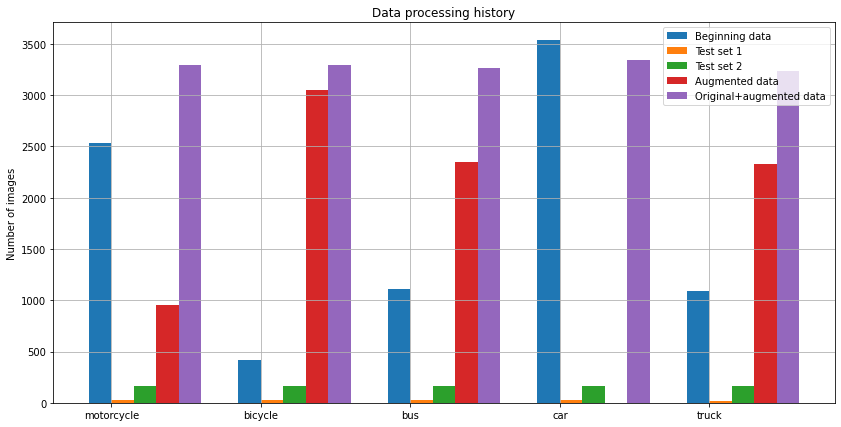

In [139]:
N = 5
beginning_data = beginning_data_stats.values()
testset1_data = testset1_stats.values()
testset2_data = testset2_stats.values()
augmented_data = augmented_data_not_path_stats.values()
original_and_augmented_data = original_and_augmented_data_not_path_stats.values()
#val_set_data = valset2_stats.values()
#train_set_data = data_dict2_stats.values()


ind = np.arange(N) 
width = 0.15
plt.figure(figsize=(14,7))       
plt.bar(ind, beginning_data, width, label='Beginning data')
plt.bar(ind + width, testset1_data, width, label='Test set 1')
plt.bar(ind + 2*width, testset2_data, width, label='Test set 2')
plt.bar(ind + 3*width, augmented_data, width, label='Augmented data')
plt.bar(ind + 4*width, original_and_augmented_data, width, label='Original+augmented data')

plt.ylabel('Number of images')
plt.title('Data processing history')

plt.xticks(ind + width / 2, ['motorcycle', 'bicycle', 'bus', 'car', 'truck'])
plt.legend(loc='best')
plt.grid(True)
plt.savefig(plots + "dataprocessinghistory.JPEG")
plt.show()